In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ner-dataset/ner_dataset.csv
/kaggle/input/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch_model.bin
/kaggle/input/bert-base-uncased/vocab.txt
/kaggle/input/glove-emb/glove.6B.100d.txt


For running and training the model, please find at https://www.kaggle.com/trangdothuy/ner-glove-bigru-model

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Input, Sequential
from keras.layers import LSTM,GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, BatchNormalization, Activation, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
from numpy.random import seed

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np 

from sklearn import preprocessing
from sklearn import model_selection

In [4]:
from tensorflow.keras.layers import TextVectorization

class Config:
    def __init__(self):
        self.MAX_LEN = 128
        self.TRAIN_BATCH_SIZE = 8
        self.VALID_BATCH_SIZE = 8
        self.EPOCHS = 20
        self.BASE_MODEL_PATH = "../input/bert-base-uncased"
        self.MODEL_PATH = "./model.bin"
        self.TRAINING_FILE = "../input/ner-dataset/ner_dataset.csv"
config = Config()



In [5]:
path_to_glove_file = "../input/glove-emb/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [6]:
data_path = config.TRAINING_FILE

df = pd.read_csv(data_path,encoding='latin-1')
df.loc[:,"Sentence #"] = df["Sentence #"].fillna(method="ffill")

sentences = df.groupby("Sentence #")["Word"].apply(list).values 
tag = df.groupby("Sentence #")["Tag"].apply(list).values

vocab_dict = {'_unk_': 1, '_w_pad_': 0}
tag_dict = {'_t_pad_': 0}

tag_seqs = []
for tag_seq in tag:
    padded_tags = []
    for tag_item in tag_seq:
        padded_tags.append(tag_item)
        if tag_item not in tag_dict:
            tag_dict[tag_item] = len(tag_dict)
    if len(padded_tags) < config.MAX_LEN:
        added_len = config.MAX_LEN - len(padded_tags)
        padded_tags += ['_t_pad_']*added_len
    assert len(padded_tags) == config.MAX_LEN
    tag_seqs.append(padded_tags)
tag2idx = tag_dict
tag_tokens = [[tag2idx[t] for t in t_seq] for t_seq in tag_seqs]
tag_tokens = np.array([to_categorical(t_seq, num_classes=len(tag_dict)) for t_seq in tag_tokens])
idx2tag = {v:k for k,v in tag2idx.items()} 

sent_list = []
for sent in sentences:
    sent_list.append(" ".join(sent))
    

(
        train_sent, 
        val_sent, 
        train_tags,
        val_tags
     ) = model_selection.train_test_split(sent_list, tag_tokens,random_state = 42,test_size = 0.2)
    

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=config.MAX_LEN)
text_ds = tf.data.Dataset.from_tensor_slices(train_sent).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

2021-12-23 01:44:51.939907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 01:44:52.038361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 01:44:52.039073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 01:44:52.040178: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18358 words (1642 misses)


In [8]:
x_train = vectorizer(np.array([[s] for s in train_sent])).numpy()
x_val = vectorizer(np.array([[s] for s in val_sent])).numpy()

In [9]:
def build_model(max_sent_length, vocab_size, hidden_size, embedding_size, 
                output_size, learning_rate,num_mlp_layers,activation,dropout_rate):
    
    
    inputs = Input(shape=(max_sent_length,), dtype='int32')
    emb = Embedding(input_dim=vocab_size,
                    output_dim = embedding_size,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable = False,
                   )(inputs)
    
    bilstm_layer_1 = Bidirectional(GRU(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(emb)
    bilstm_layer_1_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_1)
    bilstm_layer_2 = Bidirectional(GRU(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(bilstm_layer_1_dropout)
    bilstm_layer_2_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_2)

    bilstm_layer_3 = Bidirectional(GRU(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(bilstm_layer_2_dropout)
    bilstm_layer_3_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_3)

    bilstm_layer_4 = Bidirectional(GRU(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(bilstm_layer_3_dropout)
    bilstm_layer_4_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_4)
    
    h = bilstm_layer_4_dropout
    
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(0.0))(h)
        # add batch normalization layer
        new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    dense = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    model = Model(inputs, dense)
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
                                 
    return model

In [10]:
import csv
from pathlib import Path

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "GloVe_GRU_CRF.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

class StepLogCallback(keras.callbacks.Callback):
    def __init__(self):
        self.count = 0
        self.step_log = []
        self.log_fpath = Path('./step_log.csv')
    
    def on_train_batch_end(self, batch, logs=None):
        self.count += 1
        self.step_log.append([self.count, logs['loss'], logs['accuracy']])
    
    def on_epoch_end(self, epoch, logs=None):
        log_exists = self.log_fpath.exists()
        with open(self.log_fpath, 'a' if log_exists else 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if not log_exists:
                writer.writerow(['step','loss','accuracy'])
            for log in self.step_log:
                writer.writerow(log)
            self.step_log.clear()

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data, ground_file, model):
        self.count = 0
        self.test_data = test_data
        self.model = model
        self.ground_file = ground_file
        self.epoch_log = []
        self.log_fpath = Path('./epoch_log.csv')
        
    def calc_accuracy(self, preds, tags, padding_id="_t_pad_"):
        preds_flatten = preds.flatten()
        tags_flatten = tags.flatten()
        non_padding_idx = np.where(tags_flatten!=padding_id)[0]
        return sum(preds_flatten[non_padding_idx]==tags_flatten[non_padding_idx])/len(non_padding_idx)
        
    def on_epoch_end(self, epoch, logs=None):
        val_preds_numerical = self.model.predict(self.test_data)
        val_preds = np.array([[idx2tag[p] for p in preds] for preds in np.argmax(val_preds_numerical,axis=2)])
        file_dict = pkl.load(open(self.ground_file, "rb"))
        val_accuracy = self.calc_accuracy(val_preds, np.array(file_dict["tag_seq"]))
        
        print('\nValidation Set Accuracy: %f\n' % val_accuracy)
        
        self.count += 1
        log_exists = self.log_fpath.exists()
        with open(self.log_fpath, 'a' if log_exists else 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if not log_exists:
                writer.writerow(['epoch','loss','train_accuracy','val_accuracy'])
            writer.writerow([self.count, logs['loss'], logs['accuracy'], val_accuracy])
            self.epoch_log.clear()

In [11]:
input_length = config.MAX_LEN
vocab_size = num_tokens
hidden_size = 100
embedding_size = 100
output_size = train_tags.shape[2]
learning_rate = 0.0001
num_mlp_layers = 3
activation = "tanh"
dropout_rate = 0.5

In [12]:
np.random.seed(0)
tf.random.set_seed(0)
model = build_model(input_length, vocab_size, hidden_size, embedding_size, 
                    output_size, learning_rate, num_mlp_layers, activation, dropout_rate)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 100)     2000200     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128, 200)     121200      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 200)     0           bidirectional[0][0]              
______________________________________________________________________________________________

In [13]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('glove-gru-training.log', append=False)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

In [14]:
!rm -f *.csv
history = model.fit(x_train, train_tags,
                    batch_size=128, epochs=30, validation_data = (x_val, val_tags),
                    callbacks=[checkpointer,csv_logger])

Epoch 1/30


2021-12-23 01:45:08.212784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 [==============================] - 42s 105ms/step - loss: 0.1774 - accuracy: 0.9622 - val_loss: 0.1307 - val_accuracy: 0.9679


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
300/300 [==============================] - 29s 97ms/step - loss: 0.1162 - accuracy: 0.9690 - val_loss: 0.1014 - val_accuracy: 0.9708
Epoch 3/30
300/300 [==============================] - 29s 97ms/step - loss: 0.0941 - accuracy: 0.9717 - val_loss: 0.0812 - val_accuracy: 0.9744
Epoch 4/30
300/300 [==============================] - 29s 97ms/step - loss: 0.0806 - accuracy: 0.9748 - val_loss: 0.0725 - val_accuracy: 0.9762
Epoch 5/30
300/300 [==============================] - 29s 97ms/step - loss: 0.0734 - accuracy: 0.9765 - val_loss: 0.0681 - val_accuracy: 0.9776
Epoch 6/30
300/300 [==============================] - 29s 97ms/step - loss: 0.0691 - accuracy: 0.9775 - val_loss: 0.0640 - val_accuracy: 0.9787
Epoch 7/30
300/300 [==============================] - 29s 97ms/step - loss: 0.0660 - accuracy: 0.9783 - val_loss: 0.0610 - val_accuracy: 0.9798
Epoch 8/30
300/300 [==============================] - 29s 97ms/step - loss: 0.0636 - accuracy: 0.9789 - val_loss: 0.0605 - val_accuracy:

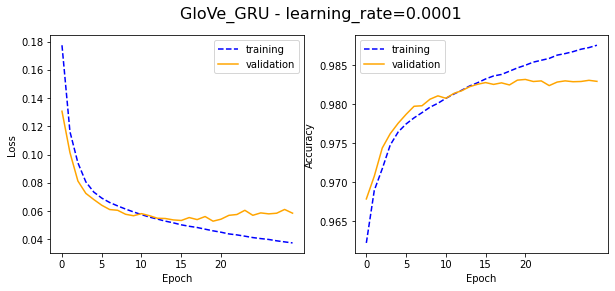

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.suptitle("GloVe_GRU - learning_rate=0.0001", fontsize=16)
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="validation", color="orange")
plt.xticks((0,5,10,15,20))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="validation", color="orange")
plt.xticks((0,5,10,15,20))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
# save model
model.save('models/GloVe_GRU_model.h5')

## Prediction

In [17]:
model =  keras.models.load_model('models/GloVe_GRU_model.h5')


In [18]:
idx2tag = {v:k for k,v in tag2idx.items()} 

In [19]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

test_preds_numerical = end_to_end_model.predict(
    [["HKUST honors faculty and staff members who have served the University for at least two decades."]]
)


test_preds = np.array([[idx2tag[p] for p in preds] for preds in np.argmax(test_preds_numerical,axis=2)])
print(test_preds.shape)
print(test_preds[0])

(1, 128)
['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-tim' 'O' 'O'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_p